# Import Library

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Load Final Data

In [2]:
df=pd.read_csv('./data/asos_selling.csv')
df

,id,timestamp,item,co_op,loc,supply,price,year,month,week,day,yemon,holiday,avg_tem,max_tem,min_tem,max_rain,hr_max_rain,max_wind,avg_sun
0,BC_A_J_20190101,2019-01-01,BC,A,J,0.0,0.00,2019,1,1,1,2019-01,1,26.677,35.3,18.5,265.4,36.6,9.8,6.546
1,BC_B_J_20190101,2019-01-01,BC,B,J,0.0,0.00,2019,1,1,1,2019-01,1,26.677,35.3,18.5,265.4,36.6,9.8,6.546
2,BC_C_J_20190101,2019-01-01,BC,C,J,0.0,0.00,2019,1,1,1,2019-01,1,26.677,35.3,18.5,265.4,36.6,9.8,6.546
3,BC_D_J_20190101,2019-01-01,BC,D,J,0.0,0.00,2019,1,1,1,2019-01,1,26.677,35.3,18.5,265.4,36.6,9.8,6.546
4,BC_E_J_20190101,2019-01-01,BC,E,J,0.0,0.00,2019,1,1,1,2019-01,1,26.677,35.3,18.5,265.4,36.6,9.8,6.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_E_S_20230302,2023-03-02,RD,E,S,97.0,6.78,2023,3,9,3,2023-03,0,21.625,34.8,11.5,121.0,25.5,5.1,6.157
59393,RD_A_S_20230303,2023-03-03,RD,A,S,160.6,6.13,2023,3,9,4,2023-03,0,21.625,34.8,11.5,121.0,25.5,5.1,6.157
59394,RD_C_S_20230303,2023-03-03,RD,C,S,0.0,0.00,2023,3,9,4,2023-03,0,21.625,34.8,11.5,121.0,25.5,5.1,6.157
59395,RD_D_S_20230303,2023-03-03,RD,D,S,85.8,6.01,2023,3,9,4,2023-03,0,21.625,34.8,11.5,121.0,25.5,5.1,6.157


# Preprocessing for Training

In [3]:
idx_list = []

for item in df['item'].unique():
    i_df = df[df['item'] == item]
    
    Q1 = i_df['price'].quantile(0.25)
    Q3 = i_df['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + 1.5 * IQR
    
    idx_list.extend(i_df[i_df['price'] > upper_bound].index)

df.drop(idx_list, inplace=True)
df.reset_index(drop=True,inplace=True)

In [4]:
hol_d=['2019-01-02','2019-02-07','2019-08-03','2020-01-02','2020-08-02',
       '2021-01-02','2021-09-23','2022-02-03','2022-08-06','2023-01-02']

t_df=df.copy()
t_df.loc[t_df['timestamp']=='2019-12-30','week']=52
t_df.loc[t_df['timestamp']=='2019-12-31','week']=52 ##1주차로들어가있음
t_df.loc[[10573,24846,26807],'supply']=0
t_df['price']=t_df['price']*100
idx=t_df[t_df['price']==0].index
t_df=t_df.drop(idx,axis=0)
t_df=t_df.reset_index(drop=True)
encoder = LabelEncoder()
# t_df['item']=encoder.fit_transform(t_df['item'].values)
# t_df['co_op']=encoder.fit_transform(t_df['co_op'].values)
# t_df['loc']=encoder.fit_transform(t_df['loc'].values)
t_df = pd.get_dummies(t_df, columns=['item', 'co_op', 'loc'])
t_df.loc[(t_df['price'] == 0) & (t_df['day'] == 5), 'holiday'] = 1
for i in range(len(hol_d)):
    t_df.loc[t_df['timestamp']==hol_d[i],'holiday']=1
t_df=t_df.sort_values('timestamp').reset_index(drop=True)

mMscaler = MinMaxScaler()
mMscaler.fit(t_df[['avg_tem','max_rain']])
mMscaled_data = mMscaler.transform(t_df[['avg_tem','max_rain']])
t_df[['avg_tem','max_rain']] = pd.DataFrame(mMscaled_data)
display(t_df)

train_df=t_df[t_df['year']!=2023]
# train_df=t_df.copy()
X=train_df.drop(['price','timestamp','supply','id','yemon','max_tem','min_tem','hr_max_rain','max_wind','avg_sun','holiday'], axis=1)
y=train_df['price']
test_df=t_df[t_df['year']==2023]
test_x=test_df.drop(['price','timestamp','supply','id','yemon','max_tem','min_tem','hr_max_rain','max_wind','avg_sun','holiday'], axis=1)
test_y=test_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

,id,timestamp,supply,price,year,month,week,day,yemon,holiday,...,item_ETG,item_RD,co_op_A,co_op_B,co_op_C,co_op_D,co_op_E,co_op_F,loc_J,loc_S
0,BC_A_J_20190103,2019-01-03,76.16,2559.0,2019,1,1,3,2019-01,0,...,False,False,True,False,False,False,False,False,True,False
1,RD_F_J_20190103,2019-01-03,4114.80,395.0,2019,1,1,3,2019-01,0,...,False,True,False,False,False,False,False,True,True,False
2,RD_D_J_20190103,2019-01-03,408.20,382.0,2019,1,1,3,2019-01,0,...,False,True,False,False,False,True,False,False,True,False
3,RD_A_J_20190103,2019-01-03,370.60,367.0,2019,1,1,3,2019-01,0,...,False,True,True,False,False,False,False,False,True,False
4,TG_A_S_20190103,2019-01-03,1905.91,2526.0,2019,1,1,3,2019-01,0,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19833,BC_C_J_20230303,2023-03-03,3.04,2934.0,2023,3,9,4,2023-03,0,...,False,False,False,False,True,False,False,False,True,False
19834,BC_B_J_20230303,2023-03-03,12.32,2558.0,2023,3,9,4,2023-03,0,...,False,False,False,True,False,False,False,False,True,False
19835,BC_A_J_20230303,2023-03-03,107.28,2850.0,2023,3,9,4,2023-03,0,...,False,False,True,False,False,False,False,False,True,False
19836,TG_C_J_20230303,2023-03-03,64.35,5175.0,2023,3,9,4,2023-03,0,...,True,False,False,False,True,False,False,False,True,False


## Find Best Hyperparameter

In [5]:
# params = {
#     'n_estimators':[2800, 3000, 3300],
#     'max_depth' : [6, 8, 10, 12], 
#     'min_samples_leaf' : [8, 12, 18],
#     'min_samples_split' : [8, 16, 20]
# }

# model = RandomForestRegressor()
# grid_cv = GridSearchCV(model , param_grid=params , cv=2, n_jobs=2, verbose=2 )
# grid_cv.fit(X_train , y_train)

# estimator =grid_cv.best_estimator_ 
# pred = estimator.predict(X_test)

# print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
# print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

# Generate Model & Train

In [6]:
#model = RandomForestRegressor()
model = RandomForestRegressor(max_depth = 12,
                              min_samples_leaf = 8,
                              min_samples_split = 16,
                              n_estimators = 3000)
model.fit(X_train, y_train)

preds = model.predict(X_test)

preds

array([8327.98056047,  423.69778166, 2269.87098187, ..., 1803.70122165,
        470.10812343, 2121.56151907])

# Evaluate

In [7]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 650.9098837098031


In [8]:
r2 = r2_score(y_test, preds)
print("R-Squared:", r2)

R-Squared: 0.925309732814882


In [9]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
results

,Actual,Predicted
11909,7667.0,8327.980560
9771,544.0,423.697782
8661,1875.0,2269.870982
14616,399.0,469.171049
6490,5515.0,5832.713661
...,...,...
8191,1513.0,1875.294455
1336,3552.0,4257.339920
5049,1515.0,1803.701222
6740,575.0,470.108123


## Calculate Importances of Variable

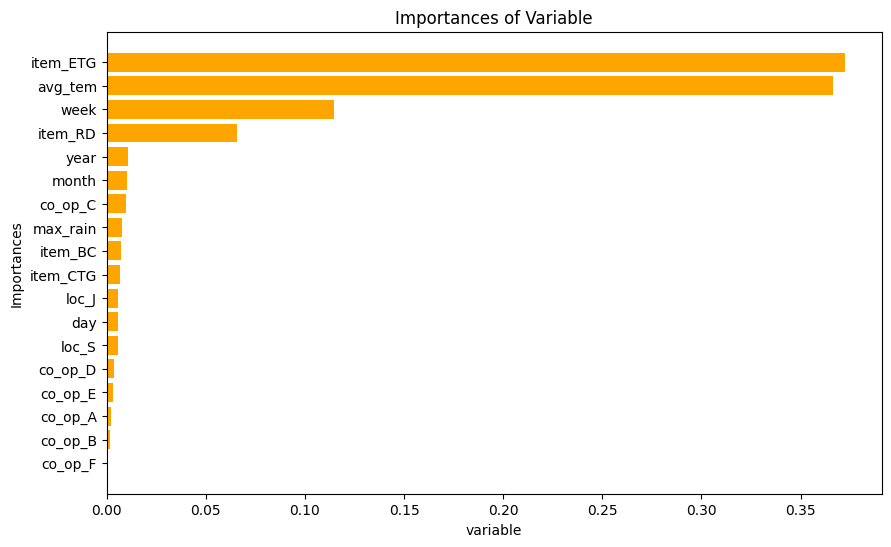

In [10]:
importances = model.feature_importances_
i_df = pd.DataFrame({
    'variable': X_train.columns,
    'Importances': importances
})


i_df = i_df.sort_values(by='Importances', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(i_df['variable'], i_df['Importances'], color='orange')
plt.xlabel('variable')
plt.ylabel('Importances')
plt.title('Importances of Variable')
plt.gca().invert_yaxis()
plt.show()

# Check 2023 Data

In [11]:
preds = model.predict(test_x)

mse = mean_squared_error(test_y, preds)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 752.4461551246403


In [12]:
test_df.insert(7,'pred_price',preds)

pred_df=pd.concat([train_df,test_df])

pred_df=pred_df[pred_df['timestamp']>='2022-11'].reset_index(drop=True)
# pred_df['price']=round(pred_df['price']/100,2)
# pred_df['pred_price']=round(pred_df['pred_price']/100,2)
pred_df

,id,timestamp,supply,price,year,month,week,day,yemon,holiday,...,item_RD,co_op_A,co_op_B,co_op_C,co_op_D,co_op_E,co_op_F,loc_J,loc_S,pred_price
0,TG_D_S_20221101,2022-11-01,165.73,1563.0,2022,11,44,1,2022-11,0,...,False,False,False,False,True,False,False,False,True,NaN
1,TG_E_S_20221101,2022-11-01,340.60,1014.0,2022,11,44,1,2022-11,0,...,False,False,False,False,False,True,False,False,True,NaN
2,TG_A_S_20221101,2022-11-01,562.09,1746.0,2022,11,44,1,2022-11,0,...,False,True,False,False,False,False,False,False,True,NaN
3,BC_E_S_20221101,2022-11-01,7.04,3283.0,2022,11,44,1,2022-11,0,...,False,False,False,False,False,True,False,False,True,NaN
4,TG_B_S_20221101,2022-11-01,462.02,1461.0,2022,11,44,1,2022-11,0,...,False,False,True,False,False,False,False,False,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,BC_C_J_20230303,2023-03-03,3.04,2934.0,2023,3,9,4,2023-03,0,...,False,False,False,True,False,False,False,True,False,2436.270087
2084,BC_B_J_20230303,2023-03-03,12.32,2558.0,2023,3,9,4,2023-03,0,...,False,False,True,False,False,False,False,True,False,2699.576863
2085,BC_A_J_20230303,2023-03-03,107.28,2850.0,2023,3,9,4,2023-03,0,...,False,True,False,False,False,False,False,True,False,2728.143649
2086,TG_C_J_20230303,2023-03-03,64.35,5175.0,2023,3,9,4,2023-03,0,...,False,False,False,True,False,False,False,True,False,4441.797077


## Visualization

C:\Users\USER\AppData\Local\Temp\ipykernel_69772\1407310510.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=pred_df,
C:\Users\USER\AppData\Local\Temp\ipykernel_69772\1407310510.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=pred_df[pred_df['timestamp']>='2023-01-22'],


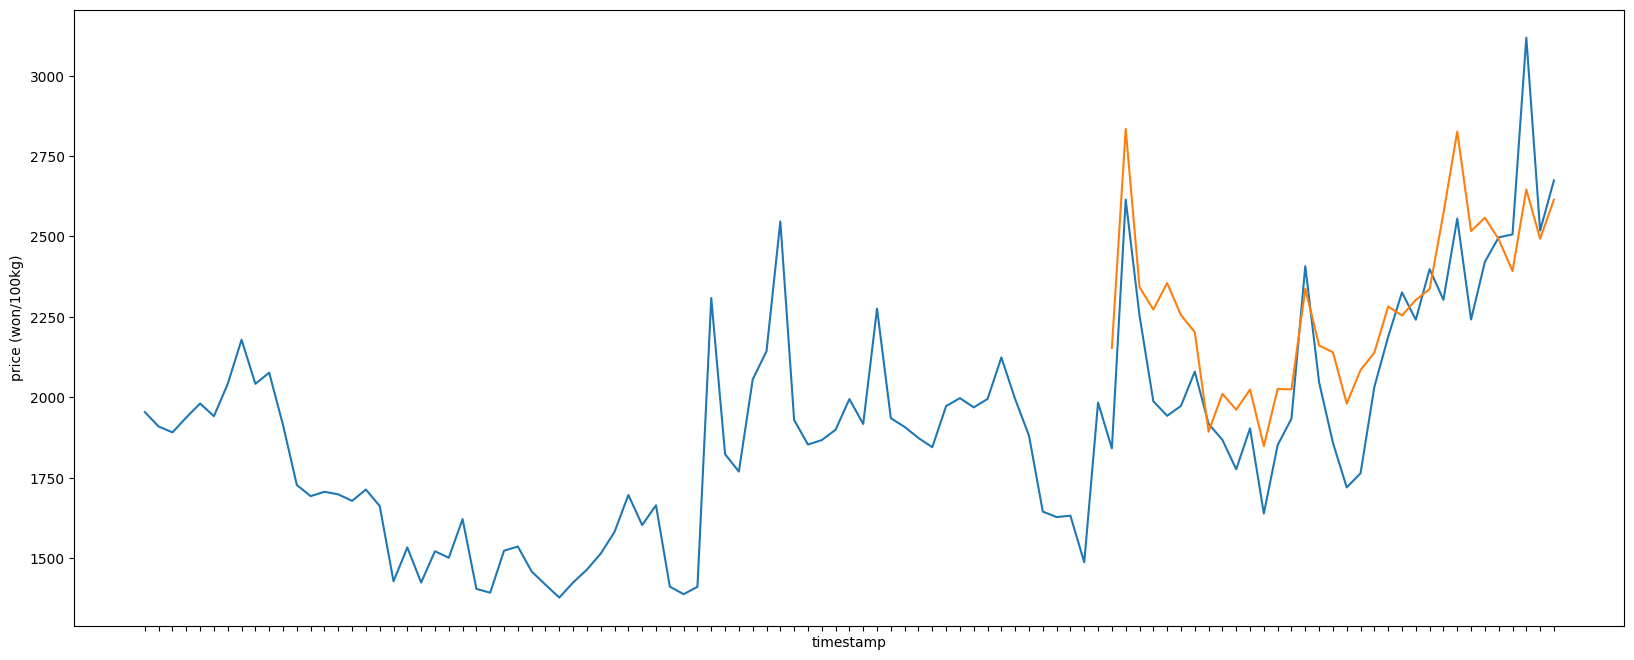

In [13]:
fig = plt.figure(figsize=(20, 8))
sns.lineplot(data=pred_df,
             x='timestamp',
             y='price',
             ci=None)
sns.lineplot(data=pred_df[pred_df['timestamp']>='2023-01-22'],
             x='timestamp',
             y='pred_price',
             ci=None)
plt.xticks(rotation=45)
plt.xlabel('timestamp')
plt.ylabel('price (won/100kg)')
ax = plt.gca()
ax.tick_params(labelbottom=False)
plt.show()